In [1]:
import sys
# Faz este append para poder importar o fitness_function que está na pasta acima
sys.path.append('../')
from fitness_function import RocketFitness, bound_values, fitness_func
import numpy as np
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from itertools import product
from tqdm import tqdm

In [2]:
bound_values

array([[1.0e+05, 1.2e+07],
       [1.5e+00, 3.5e+00],
       [2.0e-01, 3.0e-01],
       [2.0e+00, 2.0e+02],
       [1.0e+05, 1.2e+07],
       [1.5e+00, 3.5e+00],
       [2.0e-01, 3.0e-01],
       [2.0e+00, 2.0e+02],
       [1.0e+00, 6.0e+00],
       [1.0e+00, 6.0e+00]])

In [3]:
rocket_fitness = RocketFitness(bound_values, num_workers=4)
random_values = np.random.rand(100,10)
fitness_func_class = rocket_fitness.calc_fitness


In [4]:
def grid_search_rocket(fitness_fiunction):
    N = 10  # Number of parameters
    grid_resolution = 4  # Granularity of the grid

    param_ranges = [np.linspace(0, 1, grid_resolution) for _ in range(N)]
    grid_points = list(product(*param_ranges))

    return grid_points


grid_points = grid_search_rocket(fitness_func_class)

In [5]:
grid_points = np.array(grid_points)
grid_points.shape

(9765625, 10)

In [6]:
fitness_scores = fitness_func_class(grid_points)

KeyboardInterrupt: 

In [7]:
# Faz o merge dos pontos com os scores para armazenar em um dataframe e salvar, para não precisar rodar de novo
grid_points_scores = np.hstack((grid_points, fitness_scores.reshape(-1,1)))

# Salva o grid search
np.savetxt('grid_search_rocket.csv', grid_points_scores, delimiter=',')

In [3]:
# Carrega o grid search
grid_points_scores = np.loadtxt('grid_search_rocket.csv', delimiter=',')
grid_points = grid_points_scores[:, :-1]
fitness_scores = grid_points_scores[:, -1]


In [4]:
fitness_scores[fitness_scores > 0.5].shape

(573,)

In [15]:
x = fitness_scores[fitness_scores > 0.5].shape
print(f'Pontos com fitness > 0.5: {x[0]}')
x = fitness_scores[fitness_scores == 0.5].shape
print(f'Pontos com fitness = 0.5: {x[0]}')
x = fitness_scores[(fitness_scores < 0.5) & (fitness_scores > 0) ].shape
print(f'Pontos com 0 < fitness < 0.5: {x[0]}')
x = fitness_scores[fitness_scores == 0].shape
print(f'Pontos com fitness = 0: {x[0]}')

Pontos com fitness > 0.5: 573
Pontos com fitness = 0.5: 5197629
Pontos com 0 < fitness < 0.5: 52058
Pontos com fitness = 0: 4515365


In [17]:
pontos = np.where(fitness_scores > 0.5)
x_grid = grid_points[pontos]
x_min = x_grid.min(axis=0)
x_max = x_grid.max(axis=0)
print(x_grid.max(axis=0))
print(x_grid.min(axis=0))


[1.   0.25 1.   1.   1.   1.   1.   0.25 0.25 0.5 ]
[0.75 0.   0.5  0.25 0.75 0.   0.5  0.   0.25 0.25]


In [20]:
# Encontra os valores denormalizados maximos e minimos de bound_values
x_min_denorm = x_min * (bound_values[:,1] - bound_values[:,0]) + bound_values[:,0]
x_max_denorm = x_max * (bound_values[:,1] - bound_values[:,0]) + bound_values[:,0]

# Printa cada conjunto de dois valores lado a lado
for i in range(10):
    print(f'{x_min_denorm[i]:.2f} {x_max_denorm[i]:.2f}')


9025000.00 12000000.00
1.50 2.00
0.25 0.30
51.50 200.00
9025000.00 12000000.00
1.50 3.50
0.25 0.30
2.00 51.50
2.25 2.25
2.25 3.50


In [6]:
# Remove aleatoriamente pontos de fitness = 0.5 e fitness = 0 até que tenham apenas 1.000.000 pontos
np.random.seed(42)
zero_points = np.where(fitness_scores == 0)[0]
zero_points = np.random.choice(zero_points, zero_points.shape[0] - 500000, replace=False)
print(zero_points.shape)

half_points = np.where(fitness_scores == 0.5)[0]
half_points = np.random.choice(half_points, half_points.shape[0] - 500000, replace=False)
print(half_points.shape)

points_to_remove = np.concatenate((zero_points, half_points))
grid_points = np.delete(grid_points, points_to_remove, axis=0)
fitness_scores = np.delete(fitness_scores, points_to_remove, axis=0)

print(grid_points.shape)


(4015365,)
(4697629,)
(1052631, 10)


In [7]:
print(grid_points.shape)
print(fitness_scores.shape)
print(fitness_scores[fitness_scores > 0.5].shape)

(1052631, 10)
(1052631,)
(573,)


# t-SNE

In [8]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.model_selection import ParameterGrid
import numpy as np

# Supondo que 'grid_points' é o seu conjunto de dados
# grid_points = ...

# Definir um conjunto de hiperparâmetros para testar
param_grid = {
    'perplexity': [5, 30, 50, 100],
    #'learning_rate': [10, 100, 200],
    #'n_iter': [250, 1000, 3000]
}

# Melhor configuração e score
best_score = float('inf')
best_config = None
best_embedding = None

# Testar todas as combinações de hiperparâmetros
for config in tqdm(ParameterGrid(param_grid)):
    tsne = TSNE(n_components=2, perplexity=config['perplexity'],
                n_jobs=4, random_state=42)
    embedding = tsne.fit_transform(grid_points)

    # Calcula algum critério de avaliação para a qualidade do embedding
    # Por exemplo, usando a métrica de Kullback-Leibler divergência
    score = tsne.kl_divergence_

    if score < best_score:
        best_score = score
        best_config = config
        best_embedding = embedding

# Exibir o melhor resultado
print("Melhor configuração:", best_config)
print("Melhor score:", best_score)

plt.figure(figsize=(8, 6))
plt.scatter(best_embedding[:, 0], best_embedding[:, 1])
plt.title('t-SNE Visualization of Fitness Scores (Melhor Configuração)')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()


  0%|          | 0/4 [00:20<?, ?it/s]


KeyboardInterrupt: 

In [3]:
# Salva o melhor t-sne embedding para não precisar rodar de novo
np.savetxt('best_embedding.csv', best_embedding, delimiter=',')
# Carrega o melhor t-sne embedd

# t-SNE Grid Search

In [21]:
# Lê os valores de embedding de acordo com a perplexidade.
def read_embeddings_tsne(perplexity, n_iter):
    path = f'./embeddings/tsne_perplexity_{perplexity}_n_inter{n_iter}.csv'
    return np.loadtxt(path, delimiter=',')

def plot_tsne_perplexity(perplexity, n_iter):
    embedding = read_embeddings_tsne(perplexity, n_iter)
    # Separa os embeddings de acordo com bandas de fitness
    # Caso 1: se fitness = 0
    # Caso 2, se fitness > 0 e < 0.5
    # caso 3: se fitness = = 0.5
    # Caso 4: se fitness > 0.5 

    # Caso 1
    mask = fitness_scores == 0
    embedding_1 = embedding[mask]

    # Caso 2
    mask = (fitness_scores > 0) & (fitness_scores < 0.5)
    embedding_2 = embedding[mask]

    # Caso 3
    mask = fitness_scores == 0.5
    embedding_3 = embedding[mask]

    # Caso 4
    mask = fitness_scores > 0.5
    embedding_4 = embedding[mask]



    plt.figure(figsize=(8, 6))
    plt.scatter(embedding_1[:, 0], embedding_1[:, 1], color='blue', label='fitness = 0', s=0.5)
    plt.scatter(embedding_2[:, 0], embedding_2[:, 1], color='green', label='fitness > 0 e < 0.5', s=0.5)
    plt.scatter(embedding_3[:, 0], embedding_3[:, 1], color='orange', label='fitness = 0.5', s=0.5)
    plt.scatter(embedding_4[:, 0], embedding_4[:, 1], color='red', label='fitness > 0.5', s=0.5)



    #plt.colorbar()
    plt.legend()
    plt.title('t-SNE (perplexidade = {})'.format(perplexity))
    plt.xlabel('Dimensão 1')
    plt.ylabel('Dimensão 2')
    plt.show()

for i, j in zip([5, 30, 50, 100], [1000, 5000]):
    plot_tsne_perplexity(i)

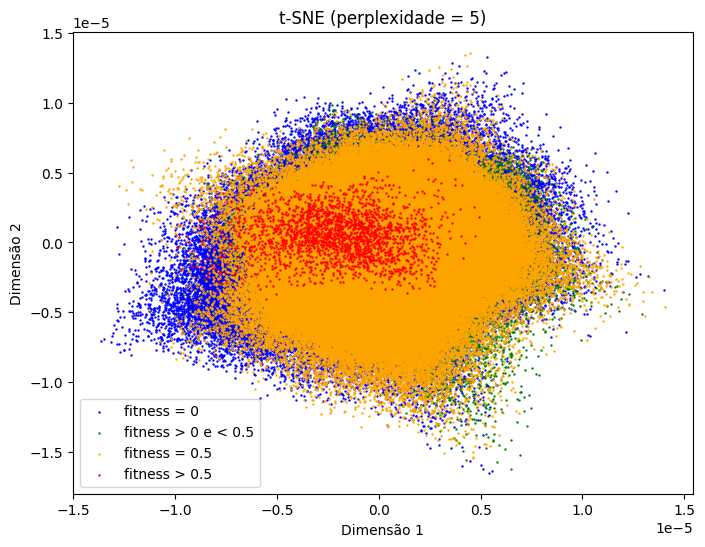

In [22]:
plot_tsne_perplexity(5, 1000)

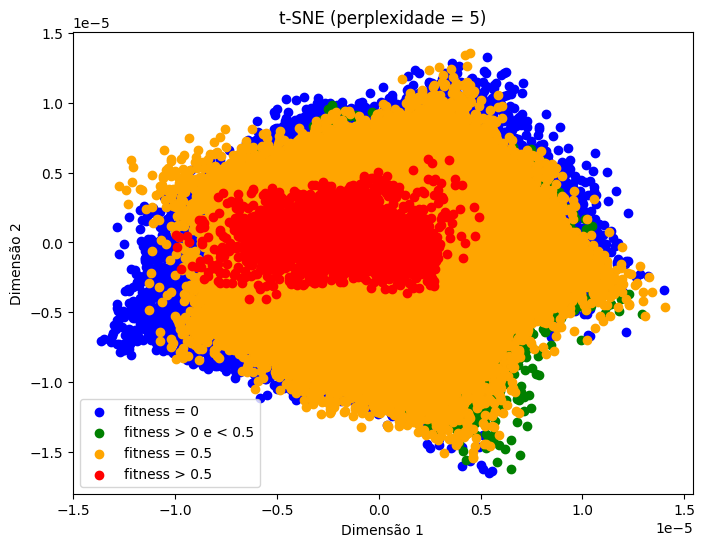

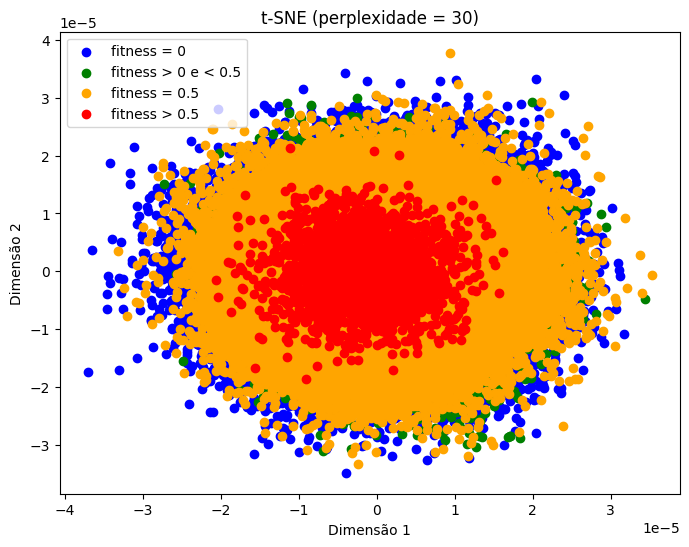

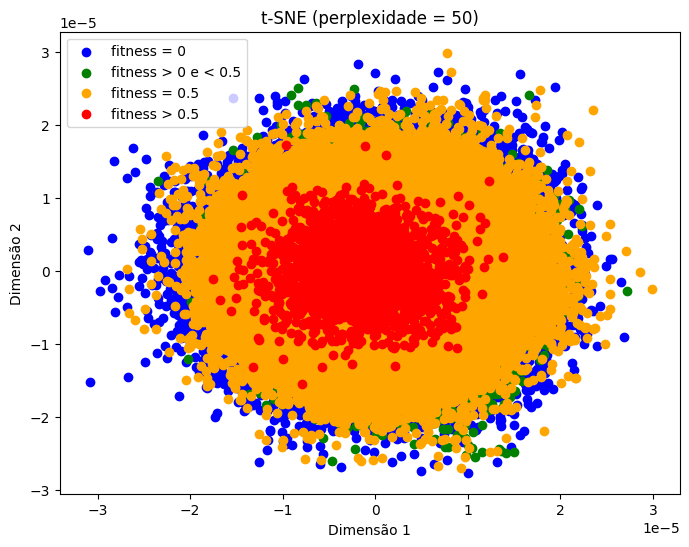

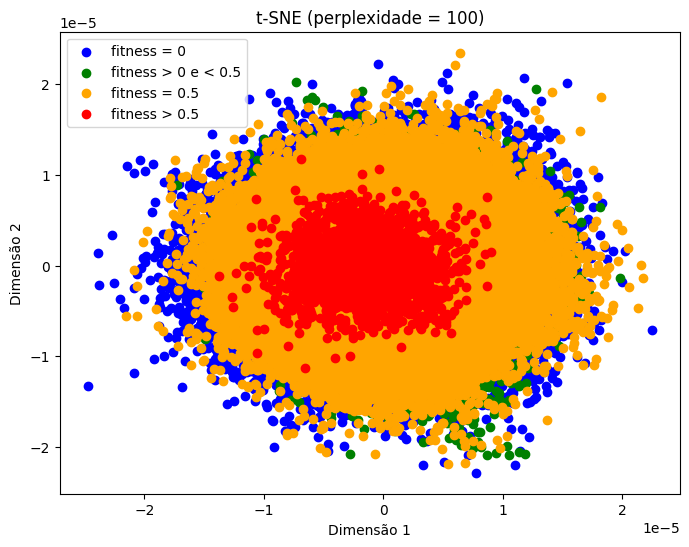

In [34]:
for i, j in [5, 30, 50, 100]:
    plot_tsne_perplexity(i)

# UMAP

In [35]:
# Lê os valores de embedding de acordo com n_neighbors e min_dist.
def read_embeddings_umap(n_neighbors, min_dist):
    path = f'./embeddings/umap_n_neighbors_{n_neighbors}_min_dist_{min_dist}_metric_euclidean.csv'
    print(path)
    return np.loadtxt(path, delimiter=',')

def plot_umap(n_neighbors, min_dist):
    embedding = read_embeddings_umap(n_neighbors, min_dist)
    # Separa os embeddings de acordo com bandas de fitness
    # Caso 1: se fitness = 0
    # Caso 2, se fitness > 0 e < 0.5
    # caso 3: se fitness = = 0.5
    # Caso 4: se fitness > 0.5 

    # Caso 1
    mask = fitness_scores == 0
    embedding_1 = embedding[mask]

    # Caso 2
    mask = (fitness_scores > 0) & (fitness_scores < 0.5)
    embedding_2 = embedding[mask]

    # Caso 3
    mask = fitness_scores == 0.5
    embedding_3 = embedding[mask]

    # Caso 4
    mask = fitness_scores > 0.5
    embedding_4 = embedding[mask]


    # # Função para calcular a intensidade (ajuste conforme necessário)
    # def calculate_intensity(data):
    #     # Exemplo: usando a norma euclidiana dos pontos como intensidade
    #     return np.linalg.norm(data, axis=1)

    # # Função para plotar cada grupo de embeddings com um gradiente de cores
    # def plot_embedding_with_gradient(embedding, color_map, label):
    #     intensity = calculate_intensity(embedding)
    #     plt.scatter(embedding[:, 0], embedding[:, 1], c=intensity, cmap=color_map, label=label)

    plt.figure(figsize=(8, 6))

    # Plotar cada grupo de embeddings
    # plt(embedding_1, 'Blues', 'fitness = 0')
    # plot_embedding_with_gradient(embedding_2, 'Greens', 'fitness > 0 e < 0.5')
    # plot_embedding_with_gradient(embedding_3, 'YlOrBr', 'fitness = 0.5')
    # plot_embedding_with_gradient(embedding_4, 'Reds', 'fitness > 0.5')

    plt.scatter(embedding_1[:, 0], embedding_1[:, 1], color='blue', label='fitness = 0')
    plt.scatter(embedding_2[:, 0], embedding_2[:, 1], color='green', label='fitness > 0 e < 0.5')
    plt.scatter(embedding_3[:, 0], embedding_3[:, 1], color='orange', label='fitness = 0.5')
    plt.scatter(embedding_4[:, 0], embedding_4[:, 1], color='red', label='fitness > 0.5')


    #plt.colorbar()
    plt.legend()
    plt.title(f'UMAP (n_neighbors = {n_neighbors}, min_dist = {min_dist})')
    plt.xlabel('Dimensão 1')
    plt.ylabel('Dimensão 2')
    plt.show()


./embeddings/umap_n_neighbors_5_min_dist_0.1_metric_euclidean.csv


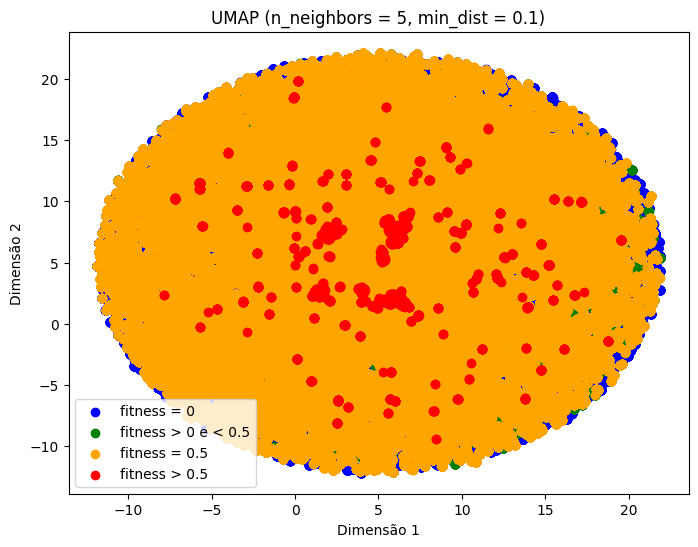

./embeddings/umap_n_neighbors_5_min_dist_0.25_metric_euclidean.csv


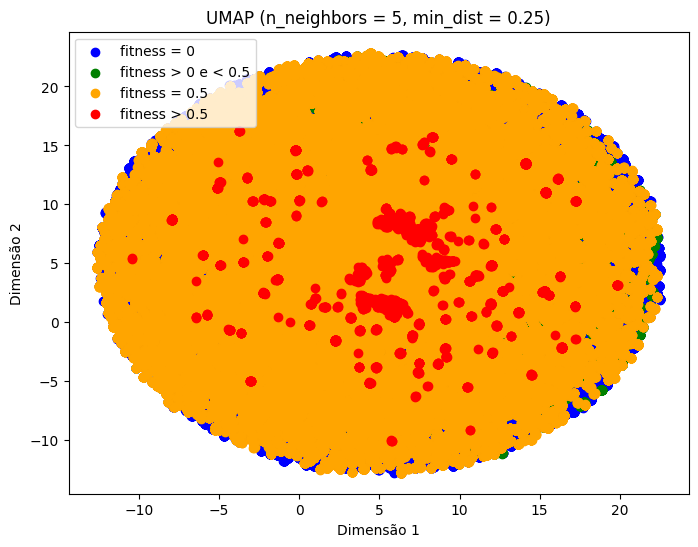

./embeddings/umap_n_neighbors_5_min_dist_0.5_metric_euclidean.csv


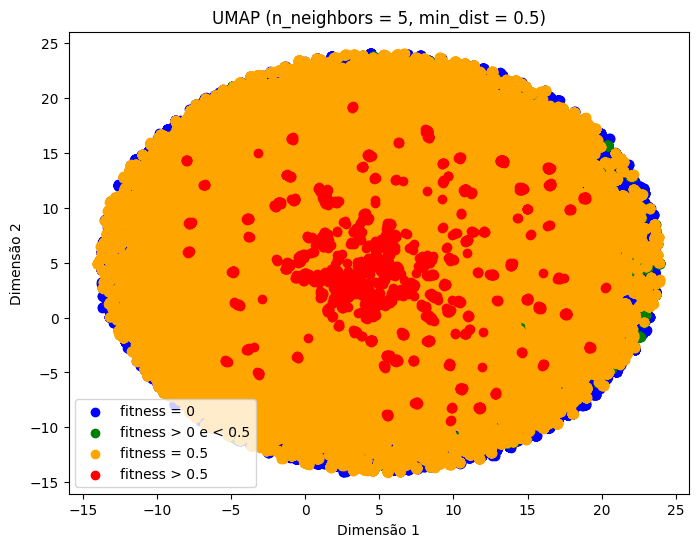

./embeddings/umap_n_neighbors_15_min_dist_0.1_metric_euclidean.csv


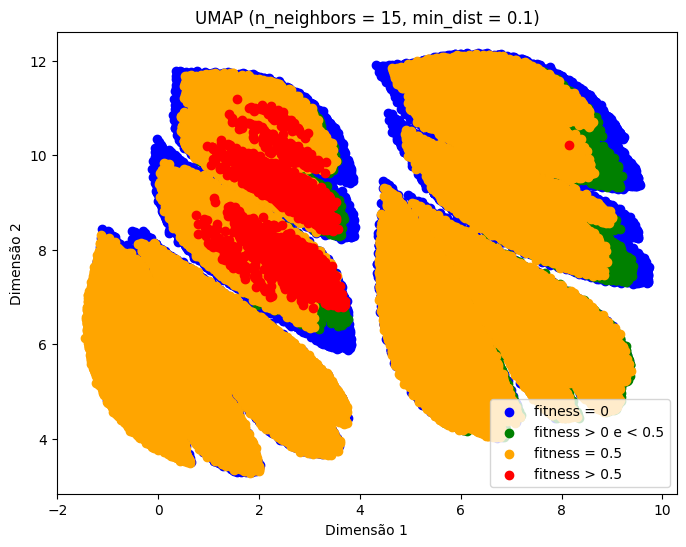

./embeddings/umap_n_neighbors_15_min_dist_0.25_metric_euclidean.csv


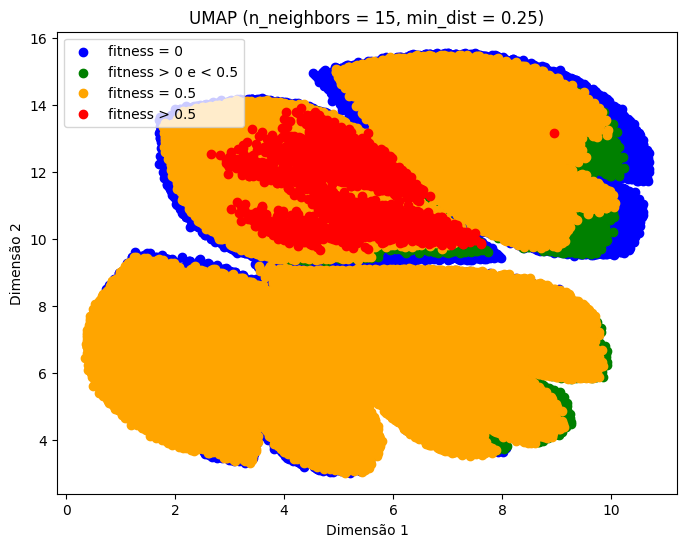

./embeddings/umap_n_neighbors_15_min_dist_0.5_metric_euclidean.csv


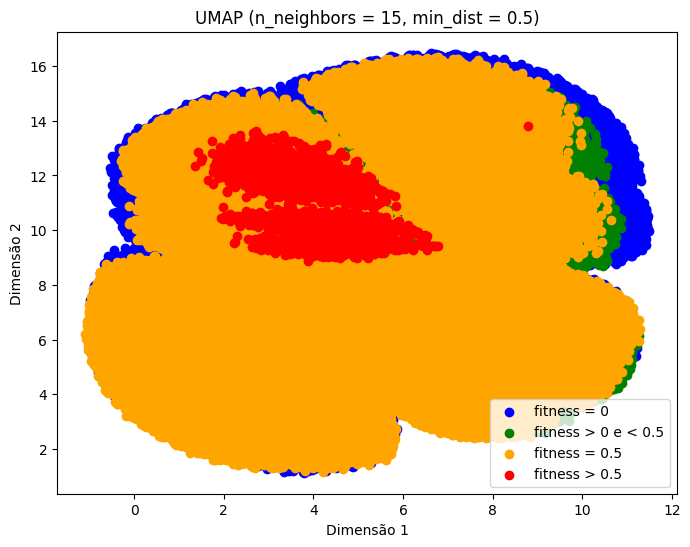

./embeddings/umap_n_neighbors_30_min_dist_0.1_metric_euclidean.csv


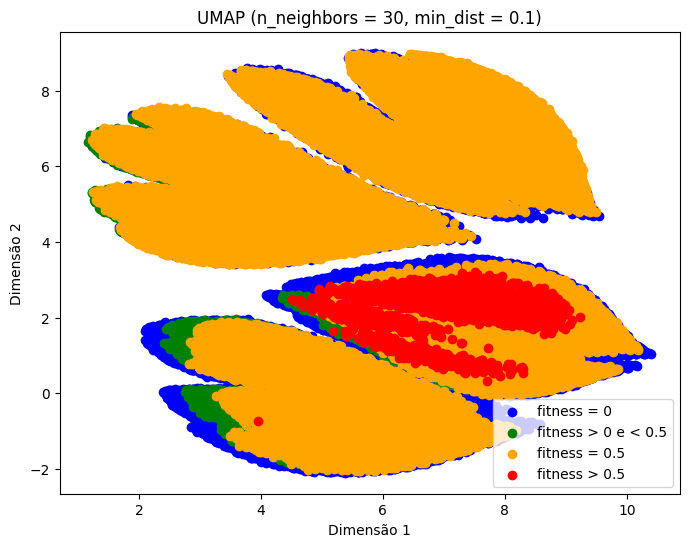

./embeddings/umap_n_neighbors_30_min_dist_0.25_metric_euclidean.csv


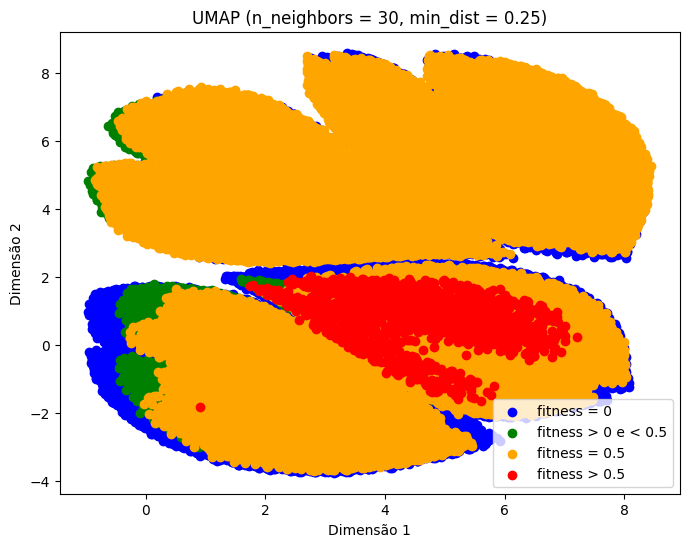

./embeddings/umap_n_neighbors_30_min_dist_0.5_metric_euclidean.csv


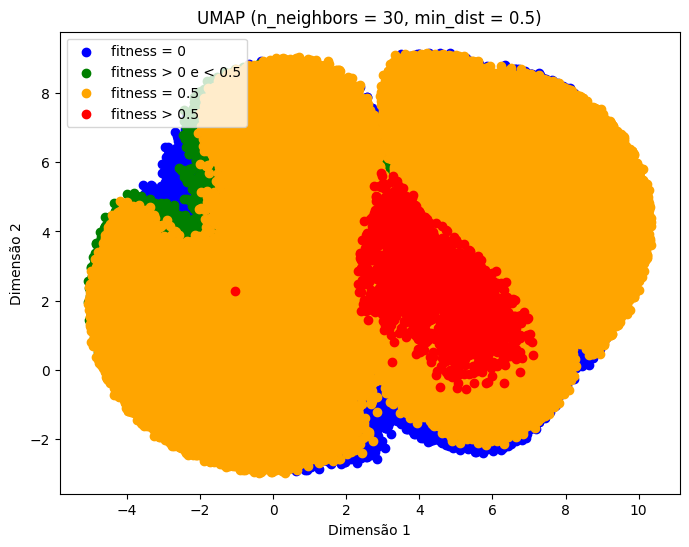

In [36]:
n_neighbors = [5, 15, 30]
min_dist = [0.1, 0.25, 0.5]
for i in n_neighbors:
    for j in min_dist:
        plot_umap(i, j)

# Plota curvas de nivel

In [9]:
embedding = read_embeddings_tsne(100, 5000)

In [10]:
embedding[0]

array([-8.81756705e-07, -4.02352185e-07])

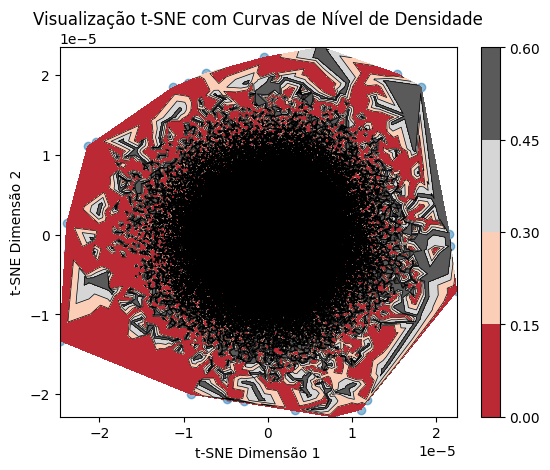

In [12]:
#X,Y = np.meshgrid(embedding[:,0], embedding[:,1])
Z = fitness_scores
X_tsne = embedding

plt.scatter(X_tsne[:, 0], X_tsne[:, 1], alpha=0.5)

# Estimando a densidade dos pontos
x = X_tsne[:, 0]
y = X_tsne[:, 1]
#xy = np.vstack([x,y])
#z = gaussian_kde(xy)(xy)
z = Z

# Plotando as curvas de nível baseadas na densidade estimada
plt.tricontour(x, y, z, levels=3, linewidths=0.5, colors='k')
plt.tricontourf(x, y, z, levels=3, cmap="RdGy")
plt.colorbar()

plt.title('Visualização t-SNE com Curvas de Nível de Densidade')
plt.xlabel('t-SNE Dimensão 1')
plt.ylabel('t-SNE Dimensão 2')
plt.show()


# Plot na mesma figura

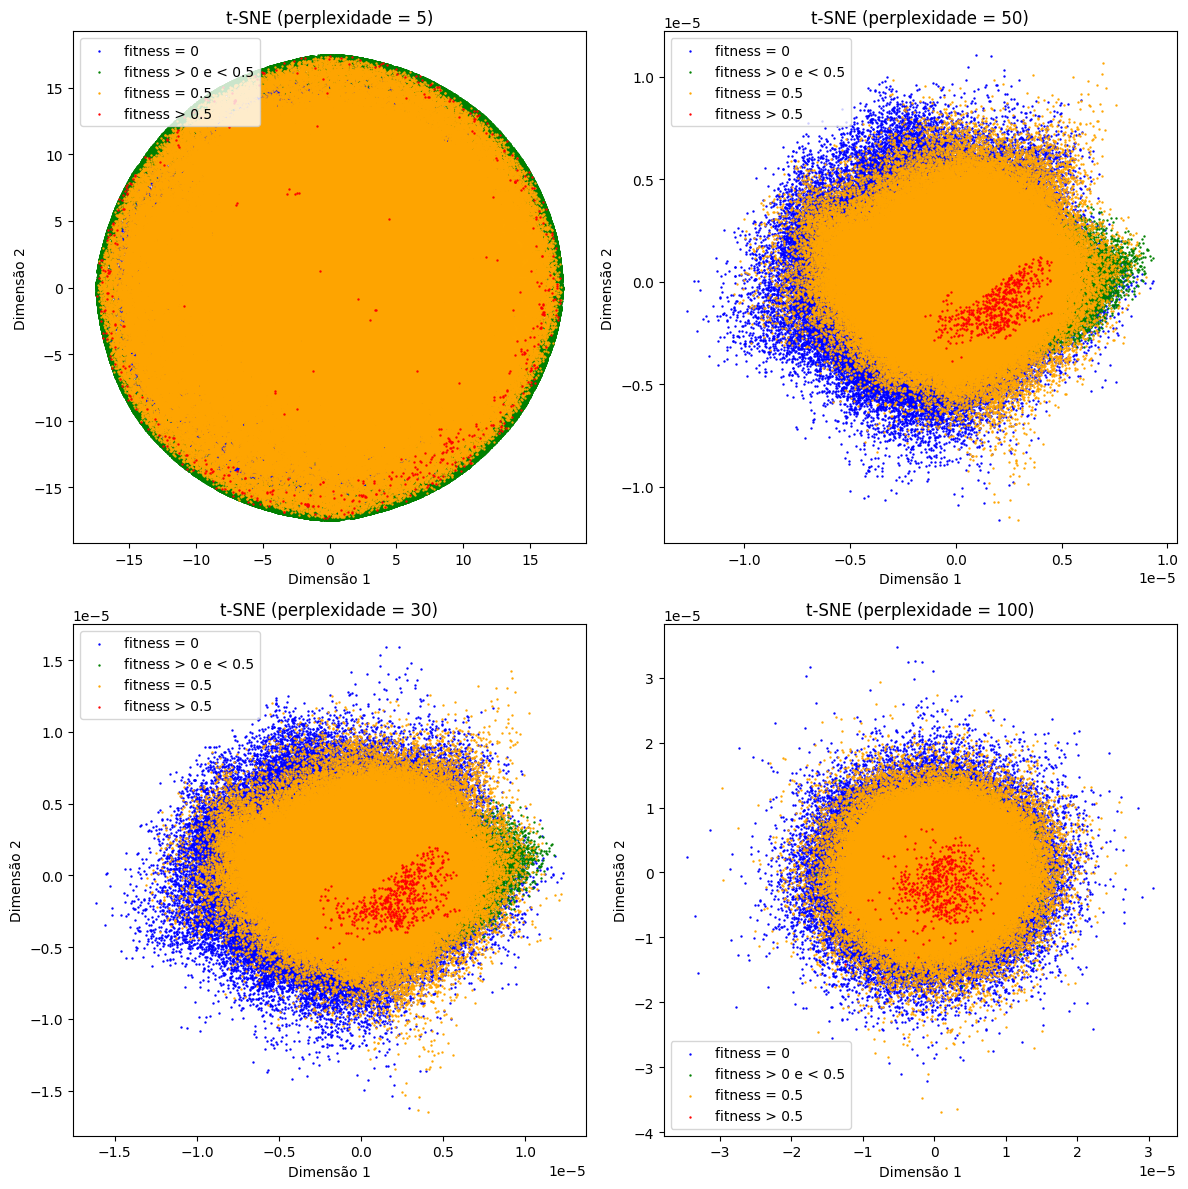

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Supõe-se que `fitness_scores` esteja definido em algum lugar do código
# fitness_scores = ...

def read_embeddings_tsne(perplexity, n_iter):
    path = f'./embeddings/tsne_perplexity_{perplexity}_n_inter{n_iter}.csv'
    return np.loadtxt(path, delimiter=',')

def plot_tsne_perplexity(ax, perplexity, n_iter):
    embedding = read_embeddings_tsne(perplexity, n_iter)
    # Separa os embeddings de acordo com bandas de fitness

    # Caso 1
    mask = fitness_scores == 0
    embedding_1 = embedding[mask]

    # Caso 2
    mask = (fitness_scores > 0) & (fitness_scores < 0.5)
    embedding_2 = embedding[mask]

    # Caso 3
    mask = fitness_scores == 0.5
    embedding_3 = embedding[mask]

    # Caso 4
    mask = fitness_scores > 0.5
    embedding_4 = embedding[mask]

    ax.scatter(embedding_1[:, 0], embedding_1[:, 1], color='blue', label='fitness = 0', s=0.5)
    ax.scatter(embedding_2[:, 0], embedding_2[:, 1], color='green', label='fitness > 0 e < 0.5', s=0.5)
    ax.scatter(embedding_3[:, 0], embedding_3[:, 1], color='orange', label='fitness = 0.5', s=0.5)
    ax.scatter(embedding_4[:, 0], embedding_4[:, 1], color='red', label='fitness > 0.5', s=0.5)

    ax.legend()
    ax.set_title(f't-SNE (perplexidade = {perplexity})')
    ax.set_xlabel('Dimensão 1')
    ax.set_ylabel('Dimensão 2')

fig, axes = plt.subplots(2, 2, figsize=(12, 12))
perplexities = [5, 30, 50, 100]
n_iters = [1000, 1000, 1000, 1000]

# Iterar sobre as perplexidades e iterações, preenchendo a grade de subplots
for i, (perplexity, n_iter) in enumerate(zip(perplexities, n_iters)):
    # Ajustar o índice para acessar o subplot correto
    row = i % 2  # Vai de 0 a 3 para cada linha
    col = i // 2  # 0 para as primeiras 4 iterações (1000), 1 para as últimas 4 (5000)
    ax = axes[row, col]
    plot_tsne_perplexity(ax, perplexity, n_iter)

plt.tight_layout()
plt.show()


./embeddings/umap_n_neighbors_5_min_dist_0.1_metric_euclidean.csv
./embeddings/umap_n_neighbors_5_min_dist_0.25_metric_euclidean.csv
./embeddings/umap_n_neighbors_5_min_dist_0.5_metric_euclidean.csv
./embeddings/umap_n_neighbors_15_min_dist_0.1_metric_euclidean.csv
./embeddings/umap_n_neighbors_15_min_dist_0.25_metric_euclidean.csv
./embeddings/umap_n_neighbors_15_min_dist_0.5_metric_euclidean.csv
./embeddings/umap_n_neighbors_30_min_dist_0.1_metric_euclidean.csv
./embeddings/umap_n_neighbors_30_min_dist_0.25_metric_euclidean.csv
./embeddings/umap_n_neighbors_30_min_dist_0.5_metric_euclidean.csv


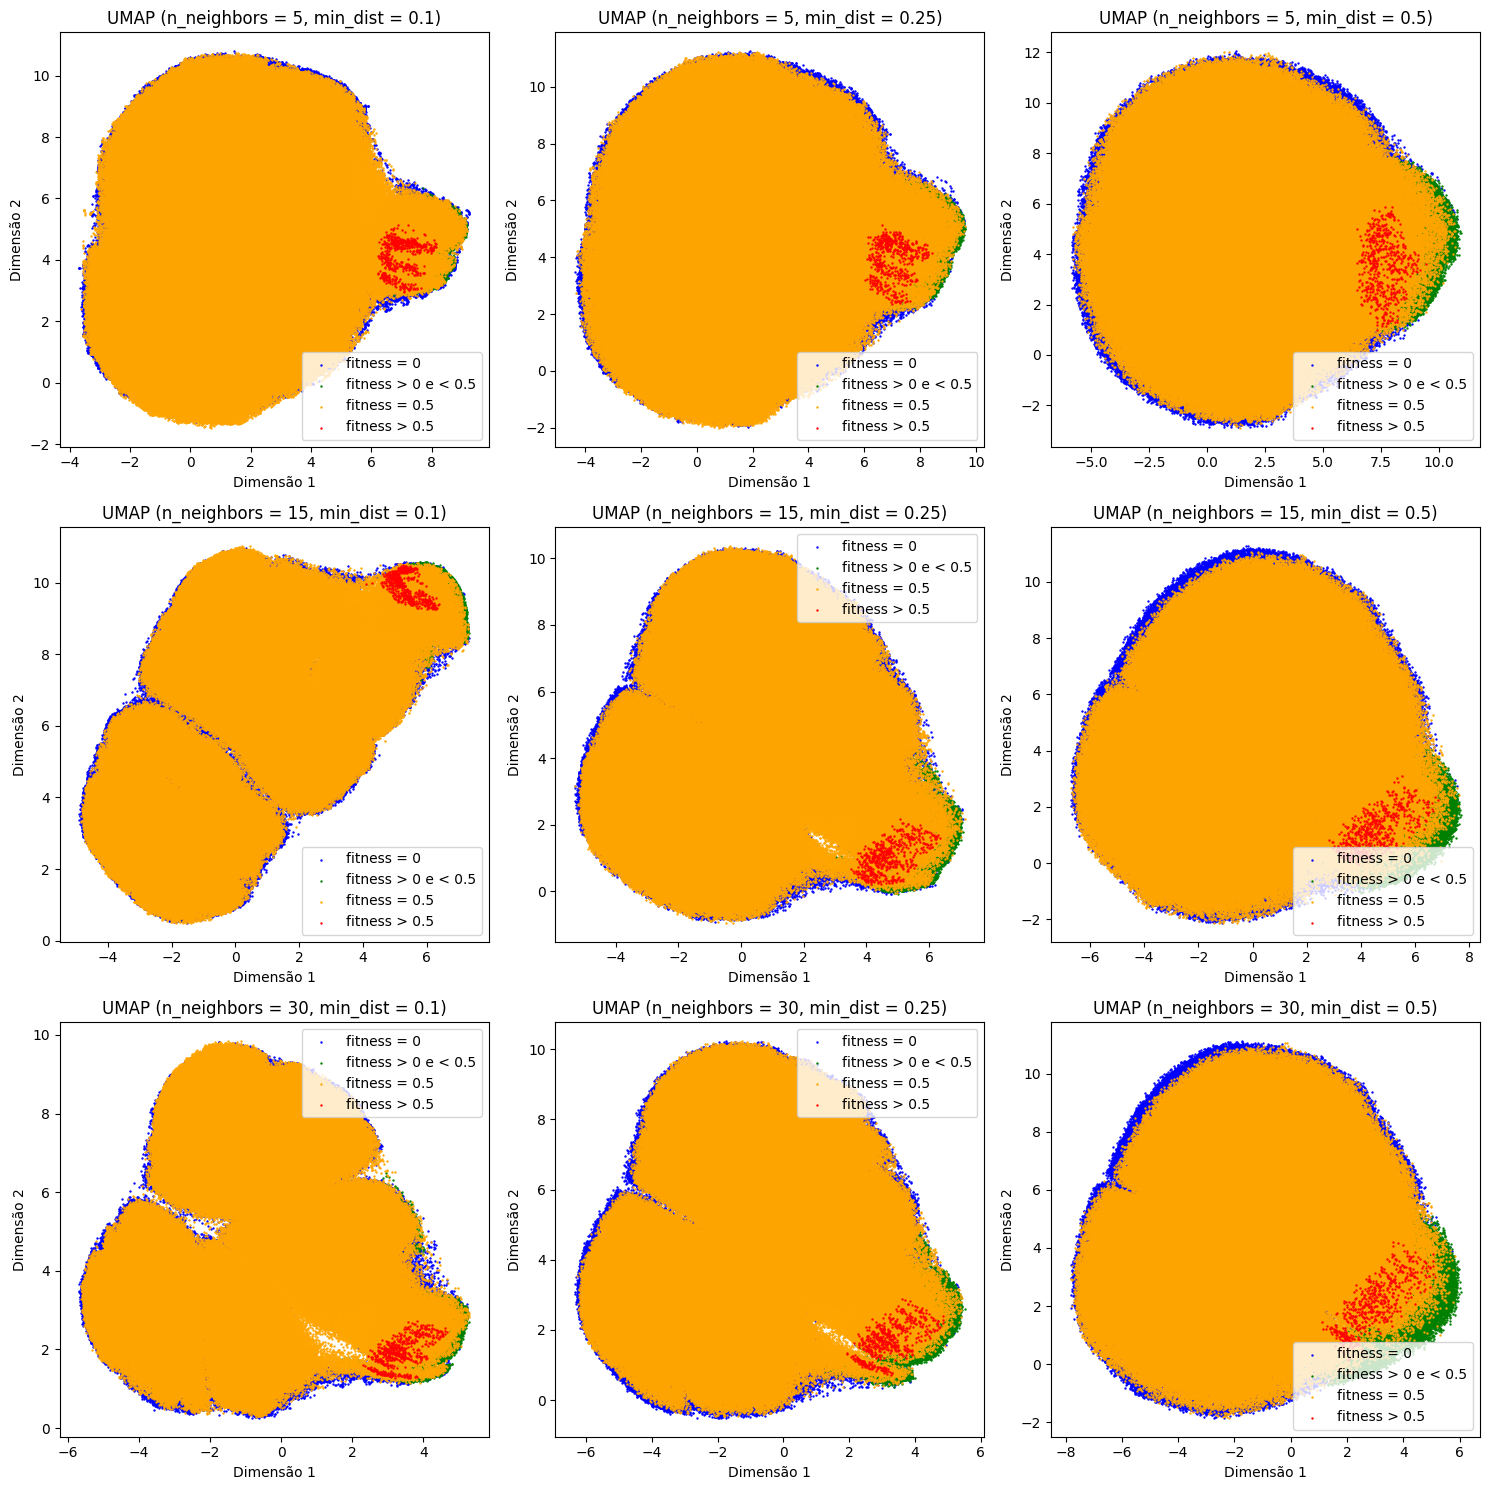

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Suposição de que a variável fitness_scores esteja definida em algum lugar do seu script
# fitness_scores = ...

# def read_embeddings_umap(n_neighbors, min_dist):
#     path = f'./embeddings/umap_n_neighbors_{n_neighbors}_min_dist_{min_dist}_metric_euclidean.csv'
#     print(path)  # Para verificação
#     return np.loadtxt(path, delimiter=',')


def read_embeddings_umap(n_neighbors, min_dist):
    path = f'./embeddings/umap_n_neighbors_{n_neighbors}_min_dist_{min_dist}_metric_euclidean.csv'
    print(path)
    return np.loadtxt(path, delimiter=',')


def plot_umap(ax, n_neighbors, min_dist):
    embedding = read_embeddings_umap(n_neighbors, min_dist)
    # Separação dos embeddings conforme fitness

    # Caso 1
    mask = fitness_scores == 0
    embedding_1 = embedding[mask]

    # Caso 2
    mask = (fitness_scores > 0) & (fitness_scores < 0.5)
    embedding_2 = embedding[mask]

    # Caso 3
    mask = fitness_scores == 0.5
    embedding_3 = embedding[mask]

    # Caso 4
    mask = fitness_scores > 0.5
    embedding_4 = embedding[mask]

    # Plotando no eixo fornecido
    ax.scatter(embedding_1[:, 0], embedding_1[:, 1], color='blue', label='fitness = 0', s=0.5)
    ax.scatter(embedding_2[:, 0], embedding_2[:, 1], color='green', label='fitness > 0 e < 0.5', s=0.5)
    ax.scatter(embedding_3[:, 0], embedding_3[:, 1], color='orange', label='fitness = 0.5', s=0.5)
    ax.scatter(embedding_4[:, 0], embedding_4[:, 1], color='red', label='fitness > 0.5', s=0.5)

    ax.legend()
    ax.set_title(f'UMAP (n_neighbors = {n_neighbors}, min_dist = {min_dist})')
    ax.set_xlabel('Dimensão 1')
    ax.set_ylabel('Dimensão 2')

# Criação da figura e dos subplots
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
axes = axes.flatten()  # Transforma a matriz de eixos em uma lista plana para fácil indexação

n_neighbors = [5, 15, 30]
min_dist = [0.1, 0.25, 0.5]

# Iteração sobre combinações de n_neighbors e min_dist para plotagem
for i, n in enumerate(n_neighbors):
    for j, d in enumerate(min_dist):
        ax = axes[i * len(min_dist) + j]
        plot_umap(ax, n, d)

plt.tight_layout()
plt.show()
